# ROSC

# The code  (re-training and evaluation)

### Imports and axiliary functions and stuff

In [3]:
%load_ext sql
%matplotlib inline

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [1]:
import os
import numpy
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import keras

/dvlscratch/SHI/users/hofman/ML/venv3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


In [2]:
with open(os.path.join('/','home','hofman','.dbpold.txt'), 'r') as f: password = f.read().strip()

In [3]:
STA = 'ROSC'

In [4]:
query = "oracle://hofman[retraining]:%s@dba1091.qandef:1521" % password
%sql $query

UsageError: Line magic function `%sql` not found.


In [5]:
% sql select count(*) from ml_features where sta=STA

UsageError: Line magic function `%sql` not found.


In [6]:
def plot(history, semilog=False):
    fig = plt.figure()
    ax = fig.add_subplot(211)
    ax.plot(history['acc'], label='acc')
    ax.plot(history['val_acc'], label='val_acc')
    ax.set_ylabel('accuracy')
    if semilog:
        ax.set_yscale('log')
    plt.legend(loc='best')
    ax = fig.add_subplot(212)
    ax.plot(history['loss'], label='loss')
    ax.plot(history['val_loss'], label='val_loss')
    plt.legend(loc='best')
    if semilog:
        ax.set_yscale('log')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')

In [7]:
#load data from oracle do pandas
with open(os.path.join('/','home','hofman','.dbpold.txt'), 'r') as f: password_old = f.read().strip()
import cx_Oracle
connection = cx_Oracle.connect('hofman[retraining]', password_old, 'dba1091.qandef')

In [30]:
#connection.close()

### What is the misclassification rate now for all arrivals in our DB?

* #(class_iphase != class_phase) / (#automatic which are not noise) 

In [15]:
#select from database required numbers
#wrong_type = %sql select count(*) from ml_features where sta=STA and class_phase != class_iphase
#total_number = %sql select count(*) from ml_features where sta=STA and phase!='N' and source!='M'
#print('Percentage of misclassified initial wave types: %3.2f%%' % (wrong_type[0][0]/total_number[0][0]*100))

In [8]:
from datetime import datetime as dt

In [9]:
dt.fromtimestamp(1483228800)

datetime.datetime(2017, 1, 1, 0, 0)

In [10]:
ts_2017 = dt(2017,1,1,0,0,0).timestamp()
ts_2018 = dt(2018,1,1,0,0,0).timestamp()
ts_2019 = dt(2019,1,1,0,0,0).timestamp()

### Dataframes per class phase type - RESTRICTION TO DATA BEFORE 2017 (1483228800)

In [136]:
query = f"select * from ml_features where sta='{STA}' and class_phase='regS' and time < {ts_2018} and retime<=1" # and# retime=0"
df_S_all = pd.read_sql(query, con=connection)

In [137]:
df_S_all.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,17164797,ROSC,1.084409e+09,Sx,regS,Sn,regS,0.225,A,0.444444,...,2.706132,3.899169,7.021817,-0.1,-0.099625,2.792882,4.562387,7.922789,4.138292,2.137861
1,17507019,ROSC,1.086313e+09,Sx,regS,Lg,regS,0.475,A,1.000000,...,1.980108,10.936259,10.936259,0.1,-0.068417,57.530349,2.501612,7.569144,1.538345,1.460103
2,17812078,ROSC,1.088271e+09,Sx,regS,Sn,regS,0.000,A,1.000000,...,1.766105,21.946600,5.846261,-0.3,-0.307167,0.876001,0.623147,9.223746,4.378884,4.050318
3,18928422,ROSC,1.095518e+09,Rg,regS,Lg,regS,0.000,A,1.000000,...,1.551942,1.729259,6.828729,0.2,0.028938,0.492923,1.923825,9.506096,2.232949,0.817611
4,20406482,ROSC,1.104102e+09,Sx,regS,Sn,regS,0.000,A,1.000000,...,2.121487,6.030964,6.030964,-0.3,-0.000063,0.346588,0.408650,0.745025,2.674965,0.792230


In [138]:
df_S_all.shape

(620, 25)

In [139]:
query = f"select * from ml_features where sta='{STA}' and class_phase='regP' and time < {ts_2018} and retime<=1" #and retime=0"""
df_P_all = pd.read_sql(query, con=connection)

In [140]:
df_P_all.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,22338592,ROSC,1.112414e+09,Pg,regP,Pn,regP,0.000,A,0.166667,...,2.547874,0.435347,0.435347,0.5,0.345350,1.689023,0.897198,0.373356,0.138736,0.103007
1,22362694,ROSC,1.112517e+09,Pg,regP,Pn,regP,0.325,A,0.166667,...,4.065278,0.506428,1.241703,0.5,0.252400,1.541458,1.274204,1.860077,1.498141,0.391241
2,22851434,ROSC,1.114461e+09,Pg,regP,Pn,regP,0.000,A,0.666667,...,1.868622,0.239157,0.239157,0.7,0.284786,0.484287,0.765046,0.251762,0.170370,0.482492
3,22856112,ROSC,1.114477e+09,Pn,regP,Pn,regP,0.000,A,0.666667,...,3.855411,0.269971,0.624807,0.4,0.314563,0.373222,0.263719,0.127349,1.069719,0.170537
4,23028894,ROSC,1.115257e+09,Pg,regP,Pn,regP,0.775,A,0.666667,...,10.305507,2.078425,2.078425,0.5,0.224100,1.968972,1.144289,0.341098,2.081716,0.567819


In [141]:
df_P_all.shape

(1232, 25)

In [142]:
query = f"select * from ml_features where sta='{STA}' and class_phase='T' and time < {ts_2018} and retime=0" #and retime=0
df_T_all = pd.read_sql(query, con=connection)

In [143]:
df_T_all.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,20366004,ROSC,1.104032e+09,P,T,PKP,T,0.0,A,0.666667,...,1.481721,0.084693,0.084693,0.2,0.21275,3.571935,0.573850,0.109025,0.817729,2.954715
1,20366006,ROSC,1.104032e+09,tx,T,PKPab,T,0.0,A,0.666667,...,2.528595,0.040712,0.040712,-0.2,-0.27175,0.829351,0.670321,0.102283,0.109600,1.434200
2,20366682,ROSC,1.104033e+09,P,T,PKP,T,0.0,A,0.666667,...,5.407794,0.021198,0.086002,0.2,0.32250,0.427270,0.627619,0.124479,0.333524,0.710492
3,20366684,ROSC,1.104033e+09,tx,T,PKPab,T,0.0,A,0.666667,...,1.717264,0.201065,0.192965,-0.2,-0.52950,0.519468,0.509692,0.411850,0.684274,1.881695
4,20366987,ROSC,1.104034e+09,P,T,PKP,T,0.0,A,0.666667,...,8.670602,0.043516,0.181296,0.2,0.09975,0.606909,0.383969,0.159971,0.458886,0.998134


In [144]:
df_T_all.shape

(6226, 25)

In [145]:
query = f"select * from ml_features where sta='{STA}' and class_phase='N' and time < {ts_2018}" # and source!='Z'"""
df_N_all = pd.read_sql(query, con=connection)

In [146]:
df_N_all.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,13585907,ROSC,1.059514e+09,N,N,None,N,0.0,A,0.666667,...,1.679058,2.096787,2.096787,0.1,0.1235,0.479314,2.368110,1.166430,0.833812,2.645326
1,13586320,ROSC,1.059518e+09,N,N,None,N,0.0,A,0.444444,...,2.120735,0.164558,0.158374,0.0,0.0000,2.073658,0.559039,2.052709,0.920494,0.372528
2,13587773,ROSC,1.059532e+09,N,N,None,N,0.0,A,0.444444,...,2.269979,4.713785,0.878032,0.0,0.0000,0.467131,0.946380,2.991900,0.985445,0.937701
3,13588475,ROSC,1.059540e+09,N,N,None,N,0.0,A,0.444444,...,1.785573,1.332674,0.657505,0.1,0.1010,1.398193,0.509374,1.425708,1.073770,0.348842
4,13588477,ROSC,1.059540e+09,N,N,None,N,0.0,A,1.000000,...,1.930438,3.655600,3.655600,0.0,0.0000,1.357197,0.777484,1.265294,1.111427,1.633819


In [147]:
df_N_all.shape

(431459, 25)

In [148]:
#save to csv
#df_ora.to_csv('URZ_pandas.csv')

In [149]:
print('regS', df_S_all.shape)
print('regP', df_P_all.shape)
print('tele', df_T_all.shape)
print('noise', df_N_all.shape)

regS (620, 25)
regP (1232, 25)
tele (6226, 25)
noise (431459, 25)


# Definition of input and output

In [150]:
# columns corresponding to input
x_indices = ['PER', 'RECT', 'PLANS', 'INANG1', 'INANG3', 'HMXMN', 'HVRATP', 'HVRAT', 'NAB', 'TAB',  
             'HTOV1', 'HTOV2', 'HTOV3', 'HTOV4', 'HTOV5']
print('features count:', len(x_indices))
# columns corresponding to output
y_indices = ['CLASS_PHASE']

metadata = ['ARID','STA','TIME','IPHASE','CLASS_IPHASE','PHASE','CLASS_PHASE','RETIME','SOURCE']

features count: 15


# Dataset for first phase of the cascade: N vs TPS

In [151]:
#counts of all classes
ns = df_S_all.shape[0]
np = df_P_all.shape[0]
nt = df_T_all.shape[0]
nn = df_N_all.shape[0]

#those from automatic
nsa = df_S_all[df_S_all['SOURCE'] != 'M'].shape[0]
npa = df_P_all[df_P_all['SOURCE'] != 'M'].shape[0]
nta = df_T_all[df_T_all['SOURCE'] != 'M'].shape[0]
nna = df_N_all[df_N_all['SOURCE'] != 'M'].shape[0]


#we build a balanced datased - the same portion of regS, regP and tele
#we have this count of phases
samp_count = min(nsa, npa, nta)

nmult = 1
#sample TPS dataset, random_state is a seed
#excelusion of manual arrivals
#ssS = df_S_all[df_S_all['SOURCE'] != 'M'].sample(nmult*nsa, random_state=11, replace=True)
#ssP = df_P_all[df_P_all['SOURCE'] != 'M'].sample(nmult*npa, random_state=13, replace=True)
#ssT = df_T_all[df_T_all['SOURCE'] != 'M'].sample(nmult*nta, random_state=17, replace=True)

ssS = df_S_all.sample(nmult*ns, random_state=11)
ssP = df_P_all.sample(nmult*np, random_state=13)
ssT = df_T_all.sample(nmult*nt, random_state=17)

#ssS = df_S_all.sample(nmult*nt, random_state=11, replace=True)
#ssP = df_P_all.sample(nmult*nt, random_state=13, replace=True)
#ssT = df_T_all.sample(nmult*nt, random_state=17, replace=True)


TPS_data = pd.concat([ssS, ssP, ssT])

#sample noise phases
N_data = df_N_all.sample(frac=1, random_state=23)

#lets shuffle dataset
TPS_data = TPS_data.sample(frac=1, random_state=51).reset_index(drop=True)
N_data = N_data.sample(frac=1, random_state=101).reset_index(drop=True)

print(ssS.shape, ssP.shape, ssT.shape)
print(TPS_data.shape)
print(N_data.shape)

(620, 25) (1232, 25) (6226, 25)
(8078, 25)
(431459, 25)


### Normalization of data

* normalization according to iwt_nnet.c : iwt_normalize()


In [152]:
# check on positivity of all features which are going to be log10-ed:)
# check TPS data
print('TPS')
print(TPS_data['HVRAT'][TPS_data['HVRAT']<=0])
print(TPS_data['HVRATP'][TPS_data['HVRATP']<=0])
print(TPS_data['HMXMN'][TPS_data['HMXMN']<=0])
print(TPS_data['HTOV1'][TPS_data['HTOV1']<=0])
print(TPS_data['HTOV2'][TPS_data['HTOV2']<=0])
print(TPS_data['HTOV3'][TPS_data['HTOV3']<=0])
print(TPS_data['HTOV4'][TPS_data['HTOV4']<=0])
print(TPS_data['HTOV5'][TPS_data['HTOV5']<=0])
# check NOISE data
print('NOISE')
print(N_data['HVRAT'][N_data['HVRAT']<=0])
print(N_data['HVRATP'][N_data['HVRATP']<=0])
print(N_data['HMXMN'][N_data['HMXMN']<=0])
print(N_data['HTOV1'][N_data['HTOV1']<=0])
print(N_data['HTOV2'][N_data['HTOV2']<=0])
print(N_data['HTOV3'][N_data['HTOV3']<=0])
print(N_data['HTOV4'][N_data['HTOV4']<=0])
print(N_data['HTOV5'][N_data['HTOV5']<=0])

TPS
Series([], Name: HVRAT, dtype: float64)
Series([], Name: HVRATP, dtype: float64)
Series([], Name: HMXMN, dtype: float64)
Series([], Name: HTOV1, dtype: float64)
Series([], Name: HTOV2, dtype: float64)
Series([], Name: HTOV3, dtype: float64)
Series([], Name: HTOV4, dtype: float64)
Series([], Name: HTOV5, dtype: float64)
NOISE
Series([], Name: HVRAT, dtype: float64)
Series([], Name: HVRATP, dtype: float64)
Series([], Name: HMXMN, dtype: float64)
Series([], Name: HTOV1, dtype: float64)
Series([], Name: HTOV2, dtype: float64)
Series([], Name: HTOV3, dtype: float64)
Series([], Name: HTOV4, dtype: float64)
Series([], Name: HTOV5, dtype: float64)


In [153]:
# normalize TPS
TPS_data_norm = TPS_data.copy(deep=True)
TPS_data_norm['INANG1'] /= 90.
TPS_data_norm['INANG3'] /= 90.
TPS_data_norm['HMXMN'] = numpy.log10(TPS_data['HMXMN'])
TPS_data_norm['HVRATP'] = numpy.log10(TPS_data['HVRATP'])
TPS_data_norm['HVRAT'] = numpy.log10(TPS_data['HVRAT'])
TPS_data_norm['HTOV1'] = numpy.log10(TPS_data['HTOV1'])
TPS_data_norm['HTOV2'] = numpy.log10(TPS_data['HTOV2'])
TPS_data_norm['HTOV3'] = numpy.log10(TPS_data['HTOV3'])
TPS_data_norm['HTOV4'] = numpy.log10(TPS_data['HTOV4'])
TPS_data_norm['HTOV5'] = numpy.log10(TPS_data['HTOV5'])

# normalize NOISE
N_data_norm = N_data.copy(deep=True)
N_data_norm['INANG1'] /= 90.
N_data_norm['INANG3'] /= 90.
N_data_norm['HMXMN'] = numpy.log10(N_data['HMXMN'])
N_data_norm['HVRATP'] = numpy.log10(N_data['HVRATP'])
N_data_norm['HVRAT'] = numpy.log10(N_data['HVRAT'])
N_data_norm['HTOV1'] = numpy.log10(N_data['HTOV1'])
N_data_norm['HTOV2'] = numpy.log10(N_data['HTOV2'])
N_data_norm['HTOV3'] = numpy.log10(N_data['HTOV3'])
N_data_norm['HTOV4'] = numpy.log10(N_data['HTOV4'])
N_data_norm['HTOV5'] = numpy.log10(N_data['HTOV5'])

### The same for manually added arrivals

In [154]:
import keras.utils

### Define train/validation ratio

In [155]:
train_validation_split_ratio = 0.95
samp_count_train = int(TPS_data_norm.shape[0] * train_validation_split_ratio)
samp_count_valid = TPS_data_norm.shape[0] - samp_count_train
print('train count=', samp_count_train, 'test count=', samp_count_valid)

train count= 7674 test count= 404


In [156]:
TPS_train = TPS_data_norm[:samp_count_train]
TPS_valid = TPS_data_norm[samp_count_train:]

samp_count_train_N = int(N_data_norm.shape[0] * train_validation_split_ratio)

N_train = N_data_norm[:samp_count_train_N]
N_valid = N_data_norm[samp_count_train_N:]

print('TPS train:',TPS_train.shape,'TPS valid:',TPS_valid.shape)
print('N train:  ',N_train.shape,  'N valid:  ',N_valid.shape)

TPS train: (7674, 25) TPS valid: (404, 25)
N train:   (409886, 25) N valid:   (21573, 25)


### Check interclass balance of TPS

In [157]:
print('T in TPS train:   ', TPS_train[TPS_train['CLASS_PHASE']=='T'].shape)
print('regP in TPS train:', TPS_train[TPS_train['CLASS_PHASE']=='regP'].shape)
print('regS in TPS train:', TPS_train[TPS_train['CLASS_PHASE']=='regS'].shape)

print('T in TPS test:    ', TPS_valid[TPS_valid['CLASS_PHASE']=='T'].shape)
print('regP in TPS test: ', TPS_valid[TPS_valid['CLASS_PHASE']=='regP'].shape)
print('regS in TPS test: ', TPS_valid[TPS_valid['CLASS_PHASE']=='regS'].shape)

T in TPS train:    (5918, 25)
regP in TPS train: (1165, 25)
regS in TPS train: (591, 25)
T in TPS test:     (308, 25)
regP in TPS test:  (67, 25)
regS in TPS test:  (29, 25)


### Form train and test sets and shuffle

In [158]:
train = pd.concat([TPS_train, N_train]).sample(frac=1, random_state=31).reset_index(drop=True)
valid =  pd.concat([TPS_valid, N_valid]).sample(frac=1, random_state=33).reset_index(drop=True)
#train.apply(pd.to_numeric, errors='ignore')
#test.apply(pd.to_numeric, errors='ignore')

# Some dataset insights

### Historgram

[Text(0,0,'PER'),
 Text(0,0,'RECT'),
 Text(0,0,'PLANS'),
 Text(0,0,'INANG1'),
 Text(0,0,'INANG3'),
 Text(0,0,'HMXMN'),
 Text(0,0,'HVRATP'),
 Text(0,0,'HVRAT'),
 Text(0,0,'NAB'),
 Text(0,0,'TAB'),
 Text(0,0,'HTOV1'),
 Text(0,0,'HTOV2'),
 Text(0,0,'HTOV3'),
 Text(0,0,'HTOV4'),
 Text(0,0,'HTOV5')]

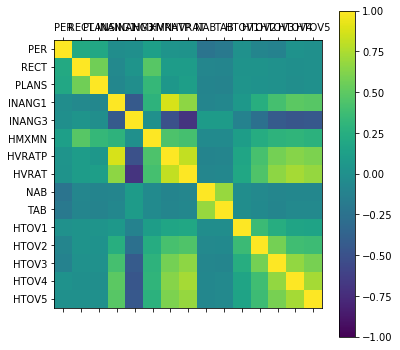

In [34]:
correlations = train[x_indices].corr()
# plot correlation matrix
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = numpy.arange(0,15,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(x_indices)
ax.set_yticklabels(x_indices)

### Extract features and class labels

In [35]:
metadata

['ARID',
 'STA',
 'TIME',
 'IPHASE',
 'CLASS_IPHASE',
 'PHASE',
 'CLASS_PHASE',
 'RETIME',
 'SOURCE']

In [159]:
train_X = train[x_indices].values.astype(float)
train_Y = train[y_indices]

valid_X = valid[x_indices].values.astype(float)
valid_Y = valid[y_indices]

train_Y_ = numpy.array(numpy.where(train_Y == 'N', 1, 0), dtype=float)
valid_Y_ = numpy.array(numpy.where(valid_Y == 'N', 1, 0), dtype=float)

#convert to categorical
train_Y = keras.utils.to_categorical(train_Y_)
valid_Y = keras.utils.to_categorical(valid_Y_)

valid_metadata = valid[metadata]

print(train_X.shape, train_Y.shape, valid_X.shape, valid_Y.shape)
print(valid_metadata.shape)
print('N phases:', train_Y_.sum())

(417560, 15) (417560, 2) (21977, 15) (21977, 2)
(21977, 9)
N phases: 409886.0


### verification, that if node1 < 0.5 => N (nodes start at 1: node1, node2)

In [160]:
train[y_indices+x_indices][:10]

,CLASS_PHASE,PER,RECT,PLANS,INANG1,INANG3,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,N,1.000000,0.927846,0.974564,0.907543,0.690939,0.033189,1.000693,-0.456491,-0.1,-0.567750,-0.477514,-0.066725,0.279159,0.690317,0.223686
1,N,0.666667,0.948068,0.963599,0.948837,0.687720,0.829095,0.831671,0.831671,-0.1,-0.058625,-0.021446,0.376762,0.379684,0.328026,0.224420
2,N,0.166667,0.847616,0.822283,0.807786,0.987719,0.307380,0.215684,-0.109114,0.0,0.000000,0.166497,-0.410133,0.231789,0.409358,0.145613
3,N,1.000000,0.999347,0.999469,0.995301,0.470202,1.663723,2.872467,2.872467,0.3,0.253583,1.847226,2.350710,2.849800,2.118447,1.794768
4,N,0.666667,0.875493,0.932856,0.186504,0.840149,0.085549,-0.754117,-0.754117,0.2,0.229500,-0.053954,-0.203757,-1.110550,-0.387393,-0.037709
5,N,0.666667,0.824045,0.732431,0.791886,0.860893,0.495585,0.301041,0.131792,0.1,-0.012875,-0.505787,0.038184,1.226846,0.079733,0.131597
6,N,0.166667,0.912580,0.869329,0.064879,0.969240,0.082359,-1.031663,-1.031663,0.0,0.000000,-0.029990,0.105207,-0.510311,-0.698309,-0.857036
7,N,0.666667,0.867811,0.932199,0.807806,0.707449,0.316153,0.691255,-0.469090,-0.1,-0.081500,0.453753,0.869818,0.037975,0.157622,-0.288216
8,N,0.444444,0.869968,0.899552,0.611630,0.311030,0.428607,-0.073927,0.429015,0.2,0.117375,0.024323,-0.054762,0.650839,0.034850,-0.403462
9,N,0.666667,0.933021,0.994593,0.101425,0.943132,0.559477,-1.095089,-1.126461,0.0,0.000000,-0.407055,-0.777961,-1.246932,-0.843215,-0.987278


In [161]:
train_Y[:10]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

#### Ground truth for all 4 classes

In [162]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(['N', 'regP', 'regS', 'T'])
valid_Y_GT = le.transform(valid[y_indices])
train_Y_GT = le.transform(train[y_indices])
print(le.transform(['N', 'regP', 'regS', 'T']))
train_Y_GT[:200]

/dvlscratch/SHI/users/hofman/ML/venv3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0 2 3 1]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0])

# Neural network N vs TPS

#### This section is based on retime=0 data with 4 times more noise than associated phases

In [58]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam

In [59]:
n_input = len(x_indices)
numpy.random.seed(11)

# create model
model = Sequential()
model.add(Dense(6, input_dim=n_input, activation='sigmoid'))
model.add(Dense(2, activation='sigmoid'))

sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=1., clipvalue=0.5)
adam = Adam(lr=0.0001) #, clipnorm, clipvalue=0.5)

model.compile(
    loss = 'binary_crossentropy', 
    optimizer = adam,  # adam, sgd
    metrics = ['accuracy'])

In [60]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 6)                 96        
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 14        
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________


In [61]:
hist_keys = ('acc', 'val_acc', 'loss', 'val_loss')

In [62]:
history = {k : [] for k in hist_keys}

In [112]:
class_weight = {0 : 1.,  # PST 1 to loss
                1: 0.007}  # noise = 0.1 weights to loss

h = model.fit(train_X[:], train_Y[:], 
          epochs=1, 
          batch_size=128, 
          verbose=1,
          shuffle=True,
          #validation_split=0.1)
          validation_data=(valid_X, valid_Y),
          class_weight=class_weight)

history = {k : history[k] + h.history[k] for k in hist_keys}

Train on 418070 samples, validate on 22004 samples
Epoch 1/1
418070/418070 [==============================] - 2s 6us/step - loss: 0.0100 - acc: 0.5646 - val_loss: 0.8096 - val_acc: 0.5911


In [341]:
print(train_Y[train_Y==0].shape, train_Y[train_Y==1].shape)
print(valid_Y[valid_Y[:,0]==1].shape, valid_Y[valid_Y[:,1]==1].shape)

(176728,) (176728,)
(865, 2) (8437, 2)


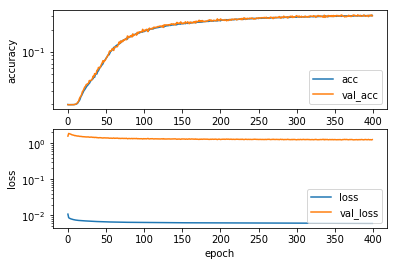

In [73]:
plot(history, semilog=True)

In [113]:
# calculate predicted values
Y_pred_ = model.predict(valid_X)
# predictions are outputted as floats from [0,1]
print(Y_pred_[:10])
print(Y_pred_.shape)
Y_pred = numpy.argmax(Y_pred_, axis=1)
Y_pred[:20]

Y_pred_.sum(axis=1).min(), Y_pred_.sum(axis=1).max()

from sklearn.metrics import confusion_matrix

# we must translate it to 0, 1 based on thresholding at 0.5
# where < 0.5 set to 0, to 1 otherwise
#Y_pred = numpy.where(Y_pred < 0.5, 0, 1)

# calculate confusion matrix
conf_mat = confusion_matrix(Y_pred,valid_Y_)
print(conf_mat)

[[0.42548963 0.5756364 ]
 [0.22606781 0.77410084]
 [0.5068193  0.49286553]
 [0.75536156 0.2434564 ]
 [0.5679933  0.43144396]
 [0.7947129  0.20651957]
 [0.421563   0.57659656]
 [0.25965875 0.73863834]
 [0.5859944  0.41304898]
 [0.48889914 0.5111671 ]]
(22004, 2)
[[  402  8967]
 [   29 12606]]


In [77]:
## confusion matrix on Train?
Y_pred = numpy.argmax(model.predict(train_X), axis=1)
conf_mat = confusion_matrix(train_Y_, Y_pred)
print(conf_mat)

[[  7542    642]
 [183726 226160]]


In [78]:
#eval on test data
model.evaluate(valid_X, valid_Y)

22004/22004 [==============================] - 0s 5us/step


[0.8324652194240011, 0.5671696055154327]

In [79]:
model.evaluate(train_X, train_Y)

418070/418070 [==============================] - 2s 6us/step: 


[0.8380828070184907, 0.55904513598187]

In [114]:
#save model and weights, NTC = contextual features correct, Rt => retime <= t seconds
filename = f'h5/{STA}_NTPS4.h5'
model.save(filename)
print('saved as %s' % filename)

saved as h5/ROSC_NTPS4.h5


# Neural network TP vs S 

#### This section is based on retime=2 data

* we need a new dataset for this

## Dataset for TP vs S

In [163]:
print(TPS_train.shape, TPS_valid.shape)

(7674, 25) (404, 25)


In [164]:
train_X_TPS = TPS_train[x_indices].values.astype(float)
train_Y_TPS = TPS_train[y_indices]

valid_X_TPS = TPS_valid[x_indices].values.astype(float)
valid_Y_TPS = TPS_valid[y_indices]

#regS = 1, T/regP = 0
train_Y_TPS_ = numpy.array(numpy.where(train_Y_TPS['CLASS_PHASE'] == 'regS', 1, 0), dtype=float)
valid_Y_TPS_ = numpy.array(numpy.where(valid_Y_TPS['CLASS_PHASE'] == 'regS', 1, 0), dtype=float)

#convert to categorical
train_Y_TPS = keras.utils.to_categorical(train_Y_TPS_)
valid_Y_TPS = keras.utils.to_categorical(valid_Y_TPS_)

print(train_X_TPS.shape, train_Y_TPS.shape, valid_X_TPS.shape, valid_Y_TPS.shape)
print('regS:', train_Y_TPS_.sum())
print('regS:', valid_Y_TPS_.sum())

(7674, 15) (7674, 2) (404, 15) (404, 2)
regS: 591.0
regS: 29.0


### test if node3 < 0.5 => S

In [165]:
TPS_train[y_indices+x_indices][:10]

,CLASS_PHASE,PER,RECT,PLANS,INANG1,INANG3,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,regP,0.666667,0.915865,0.920188,0.228022,0.751182,0.169919,-0.795909,-0.458585,0.6,0.251500,-0.943265,-0.418258,-0.207482,-0.336637,-0.364165
1,T,0.444444,0.872048,0.886705,0.724124,0.706868,0.476029,0.187730,0.187730,0.0,0.000000,0.664468,-0.064943,0.635618,0.283354,0.111935
2,T,0.666667,0.895167,0.873158,0.192272,0.658974,0.191650,-0.805450,-0.255398,0.5,0.424300,-0.129578,-0.236637,0.406888,-0.108466,-0.912508
3,T,0.166667,0.848794,0.705636,0.434138,0.487443,0.455965,-0.378438,0.187338,0.5,0.292550,-0.253343,-0.642693,-0.050289,0.166643,-0.264986
4,regP,1.000000,0.760262,0.858654,0.436444,0.968477,0.382051,-0.300499,-0.025734,0.7,0.287321,-0.129330,0.041746,-0.039785,-0.418400,0.334355
5,regS,1.000000,0.866061,0.919953,0.896081,0.021311,0.353481,0.690334,1.091496,0.0,0.000000,0.140162,0.441176,0.571070,0.175253,0.135480
6,regP,0.166667,0.852720,0.937235,0.907576,0.936418,0.430551,0.501679,0.158102,0.5,0.360400,-0.280168,-0.020560,-0.574477,0.282215,-0.172882
7,T,0.666667,0.885827,0.986668,0.504439,0.535022,0.155865,-0.152665,-0.152665,0.0,0.001250,-0.596896,-0.075121,-0.276594,-0.278098,0.170963
8,T,0.166667,0.761913,0.725491,0.237372,0.775600,0.072221,-0.485541,-0.485541,0.3,0.159083,0.589652,-0.316121,0.207837,0.294324,-0.166786
9,regS,0.666667,0.910606,0.981440,0.950639,0.069957,0.593861,1.112981,1.442208,0.2,0.268201,-0.600066,0.257567,0.486400,1.466053,-0.037870


In [166]:
train_Y_TPS[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

### Manually added datasets for testing

In [92]:
"""
#those manually added
nsm = df_S_all[df_S_all['SOURCE'] == 'M'].shape[0]
npm = df_P_all[df_P_all['SOURCE'] == 'M'].shape[0]
ntm = df_T_all[df_T_all['SOURCE'] == 'M'].shape[0]
nnm = df_N_all[df_N_all['SOURCE'] == 'M'].shape[0]

#we build a balanced datased - the same portion of regS, regP and tele
#we have this count of phases
man_samp_count = min(nsm, npm, ntm)

#sample TPS dataset, random_state is a seed
mssS = df_S_all[df_S_all['SOURCE'] == 'M'].sample(man_samp_count, random_state=11)
mssP = df_P_all[df_P_all['SOURCE'] == 'M'].sample(man_samp_count)
mssT = df_T_all[df_T_all['SOURCE'] == 'M'].sample(man_samp_count)
MTPS_data = pd.concat([mssS, mssP, mssT])


#normalize

MTPS_data_norm = MTPS_data.copy(deep=True)
MTPS_data_norm['INANG1'] /= 90.
MTPS_data_norm['INANG3'] /= 90.
MTPS_data_norm['HMXMN'] = numpy.log10(MTPS_data['HMXMN'])
MTPS_data_norm['HVRATP'] = numpy.log10(MTPS_data['HVRATP'])
MTPS_data_norm['HVRAT'] = numpy.log10(MTPS_data['HVRAT'])
MTPS_data_norm['HTOV1'] = numpy.log10(MTPS_data['HTOV1'])
MTPS_data_norm['HTOV2'] = numpy.log10(MTPS_data['HTOV2'])
MTPS_data_norm['HTOV3'] = numpy.log10(MTPS_data['HTOV3'])
MTPS_data_norm['HTOV4'] = numpy.log10(MTPS_data['HTOV4'])
MTPS_data_norm['HTOV5'] = numpy.log10(MTPS_data['HTOV5'])

#manually added noise makes nos sense - we do not sanmple N

#lets shuffle dataset
MTPS_data_norm = MTPS_data_norm.sample(frac=1).reset_index(drop=True)

manual_X = MTPS_data_norm[x_indices].values.astype(float)
#regS = 0, T/regP = 1
manual_Y_TPS_ = numpy.array(numpy.where(MTPS_data_norm[y_indices] == 'regS', 1, 0), dtype=float)
manual_Y_TPS = keras.utils.to_categorical(manual_Y_TPS_)

print(manual_X.shape, manual_Y_TPS.shape, manual_Y_TPS_.shape)
"""

"\n#those manually added\nnsm = df_S_all[df_S_all['SOURCE'] == 'M'].shape[0]\nnpm = df_P_all[df_P_all['SOURCE'] == 'M'].shape[0]\nntm = df_T_all[df_T_all['SOURCE'] == 'M'].shape[0]\nnnm = df_N_all[df_N_all['SOURCE'] == 'M'].shape[0]\n\n#we build a balanced datased - the same portion of regS, regP and tele\n#we have this count of phases\nman_samp_count = min(nsm, npm, ntm)\n\n#sample TPS dataset, random_state is a seed\nmssS = df_S_all[df_S_all['SOURCE'] == 'M'].sample(man_samp_count, random_state=11)\nmssP = df_P_all[df_P_all['SOURCE'] == 'M'].sample(man_samp_count)\nmssT = df_T_all[df_T_all['SOURCE'] == 'M'].sample(man_samp_count)\nMTPS_data = pd.concat([mssS, mssP, mssT])\n\n\n#normalize\n\nMTPS_data_norm = MTPS_data.copy(deep=True)\nMTPS_data_norm['INANG1'] /= 90.\nMTPS_data_norm['INANG3'] /= 90.\nMTPS_data_norm['HMXMN'] = numpy.log10(MTPS_data['HMXMN'])\nMTPS_data_norm['HVRATP'] = numpy.log10(MTPS_data['HVRATP'])\nMTPS_data_norm['HVRAT'] = numpy.log10(MTPS_data['HVRAT'])\nMTPS_data

#### Manual dataset ground truth

In [93]:
"""
manual_Y_GT = le.transform(MTPS_data_norm[y_indices])
manual_Y_GT[:10]
"""

'\nmanual_Y_GT = le.transform(MTPS_data_norm[y_indices])\nmanual_Y_GT[:10]\n'

### Neural network

In [167]:
history_TPS = {k : [] for k in hist_keys}

n_input = len(x_indices)
numpy.random.seed(11)

# create model
model_TPS = Sequential()
model_TPS.add(Dense(6, input_dim=n_input, activation='sigmoid'))
model_TPS.add(Dense(2, activation='sigmoid'))

adam = Adam(lr=0.0001)

model_TPS.compile(
    loss = 'binary_crossentropy', 
    optimizer = adam,  # adam, sgd
    metrics = ['accuracy'])

In [168]:
model_TPS.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 6)                 96        
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 14        
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________


In [199]:
class_weight = {0 : 0.2,  # PT is five times more abundant
                1: 1.}  # S = 1 weights to loss
h = model_TPS.fit(train_X_TPS[:], train_Y_TPS[:], 
          epochs=1, 
          batch_size=128, 
          verbose=1,
          shuffle=True,
          #validation_split=0.1)
          validation_data=([valid_X_TPS, valid_Y_TPS]),
          class_weight=class_weight)

history_TPS = {k : history_TPS[k] + h.history[k] for k in hist_keys}

Train on 7674 samples, validate on 404 samples
Epoch 1/1
7674/7674 [==============================] - 0s 6us/step - loss: 0.0960 - acc: 0.8282 - val_loss: 0.3357 - val_acc: 0.8280


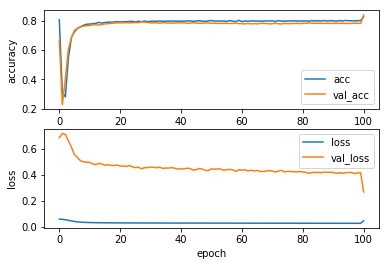

In [103]:
plot(history_TPS)

In [202]:
#NC = nodes correct
filename = f'h5/{STA}_TPS1.h5'
model_TPS.save(filename)
print(filename)

h5/ROSC_TPS1.h5


In [113]:
model_TPS.evaluate(valid_X_TPS, valid_Y_TPS)

865/865 [==============================] - 0s 18us/step


[0.2625177972578589, 0.8329479768786127]

In [100]:
min(valid_Y_TPS_), max(valid_Y_TPS_)
valid_Y_TPS_.shape
sum(valid_Y_TPS_)

45.0

#### Test data confusion matrix

In [200]:
Y_pred = numpy.reshape(numpy.argmax(model_TPS.predict(valid_X_TPS), axis=1), (valid_X_TPS.shape[0],1))
print(Y_pred.shape)
# calculate confusion matrix
C = confusion_matrix( Y_pred, valid_Y_TPS_)
print(C)

(404, 1)
[[312   6]
 [ 63  23]]


In [115]:
print(valid_X_TPS.shape)
print(valid_Y_TPS.shape)
print(valid_Y_TPS_.shape)
print(min(Y_pred), max(Y_pred))
print(min(valid_Y_TPS_), max(valid_Y_TPS_))
print(sum(valid_Y_TPS_), sum(Y_pred))

(865, 15)
(865, 2)
(865,)
[0] [1]
0.0 1.0
45.0 [175]


In [116]:
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

Accuracy: 83.35%


# Neural network T vs regP 

#### This section is based on retime=2 data

* we need a new dataset for this

### Dataset for T vs regP

In [212]:
#exclude regS
TP_train = TPS_train[TPS_train['CLASS_PHASE'] != 'regS']
TP_valid  = TPS_valid [TPS_valid ['CLASS_PHASE'] != 'regS']

In [213]:
train_X_TP = TP_train[x_indices].values.astype(float)
train_Y_TP = TP_train[y_indices]

valid_X_TP = TP_valid[x_indices].values.astype(float)
valid_Y_TP = TP_valid[y_indices]

#regS = 0, T/regP = 1
train_Y_TP_ = numpy.array(numpy.where(train_Y_TP['CLASS_PHASE'] == 'regP', 1, 0), dtype=float)
valid_Y_TP_ = numpy.array(numpy.where(valid_Y_TP['CLASS_PHASE'] == 'regP', 1, 0), dtype=float)

#convert to categorical
train_Y_TP = keras.utils.to_categorical(train_Y_TP_)
valid_Y_TP = keras.utils.to_categorical(valid_Y_TP_)

print(train_X_TP.shape, train_Y_TP.shape, valid_X_TP.shape, valid_Y_TP.shape)
print(sum(train_Y_TP_))

(7083, 15) (7083, 2) (375, 15) (375, 2)
1165.0


### test if node5 < 0.5 => P

In [214]:
TP_train[y_indices + x_indices][:10]

,CLASS_PHASE,PER,RECT,PLANS,INANG1,INANG3,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,regP,0.666667,0.915865,0.920188,0.228022,0.751182,0.169919,-0.795909,-0.458585,0.6,0.251500,-0.943265,-0.418258,-0.207482,-0.336637,-0.364165
1,T,0.444444,0.872048,0.886705,0.724124,0.706868,0.476029,0.187730,0.187730,0.0,0.000000,0.664468,-0.064943,0.635618,0.283354,0.111935
2,T,0.666667,0.895167,0.873158,0.192272,0.658974,0.191650,-0.805450,-0.255398,0.5,0.424300,-0.129578,-0.236637,0.406888,-0.108466,-0.912508
3,T,0.166667,0.848794,0.705636,0.434138,0.487443,0.455965,-0.378438,0.187338,0.5,0.292550,-0.253343,-0.642693,-0.050289,0.166643,-0.264986
4,regP,1.000000,0.760262,0.858654,0.436444,0.968477,0.382051,-0.300499,-0.025734,0.7,0.287321,-0.129330,0.041746,-0.039785,-0.418400,0.334355
6,regP,0.166667,0.852720,0.937235,0.907576,0.936418,0.430551,0.501679,0.158102,0.5,0.360400,-0.280168,-0.020560,-0.574477,0.282215,-0.172882
7,T,0.666667,0.885827,0.986668,0.504439,0.535022,0.155865,-0.152665,-0.152665,0.0,0.001250,-0.596896,-0.075121,-0.276594,-0.278098,0.170963
8,T,0.166667,0.761913,0.725491,0.237372,0.775600,0.072221,-0.485541,-0.485541,0.3,0.159083,0.589652,-0.316121,0.207837,0.294324,-0.166786
10,T,0.166667,0.700621,0.605070,0.217387,0.482493,0.606495,-0.469041,0.036321,0.3,0.286667,-0.029907,0.321974,-0.012243,0.330989,-0.082243
11,regP,0.166667,0.946165,0.533211,0.308751,0.855438,0.501422,-0.717852,-0.202292,0.3,0.366000,-0.457542,-0.799215,-0.134361,0.502780,-0.529109


In [215]:
train_Y_TP[:10]

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

### Neural network

In [216]:
history_TP = {k : [] for k in hist_keys}
n_input = len(x_indices)
numpy.random.seed(11)

# create model
model_TP = Sequential()
model_TP.add(Dense(6, input_dim=n_input, activation='sigmoid'))
model_TP.add(Dense(2, activation='sigmoid'))

adam = Adam(lr=0.0001)

model_TP.compile(
    loss = 'binary_crossentropy', 
    optimizer = adam,  # adam, sgd
    metrics = ['accuracy'])

In [238]:
class_weight = {0 : 0.25,  # T is several times more abundant
                1: 1}  # P
h = model_TP.fit(train_X_TP[:], train_Y_TP[:], 
          epochs=1, 
          batch_size=128, 
          verbose=1,
          shuffle=True,
          #validation_split=0.1)
          validation_data=([valid_X_TP, valid_Y_TP]),
          class_weight=class_weight)

history_TP = {k : history_TP[k] + h.history[k] for k in hist_keys}

Train on 7083 samples, validate on 375 samples
Epoch 1/1
7083/7083 [==============================] - 0s 6us/step - loss: 0.2174 - acc: 0.7073 - val_loss: 0.5249 - val_acc: 0.7533


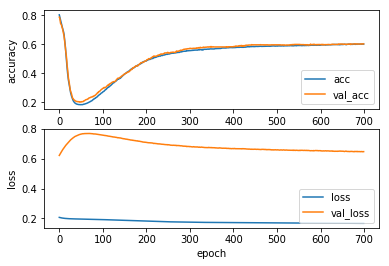

In [224]:
plot(history_TP)

In [240]:
#NC = nodes correct
filename = f'h5/{STA}_TP3.h5'
model_TP.save(filename)
print('saved as %s ' % filename)

saved as h5/ROSC_TP3.h5 


In [241]:
model_TP.evaluate(valid_X_TP, valid_Y_TP)

375/375 [==============================] - 0s 12us/step


[0.5248993895848593, 0.7533333322207133]

#### Test data confusion matrix

In [239]:
Y_pred = numpy.reshape(numpy.argmax(model_TP.predict(valid_X_TP), axis=1), (valid_X_TP.shape[0],1))

# calculate confusion matrix
conf_mat = confusion_matrix( Y_pred, valid_Y_TP_)
print(conf_mat)

[[235  17]
 [ 73  50]]


In [ ]:
[[624 102]
 [ 87 251]]


# Cascade of all three models

In [42]:
from keras.models import load_model

In [119]:
model_NTPS = load_model(f'h5/{STA}_NTPS4.h5')
model_STP = load_model(f'h5/{STA}_TPS.h5')
model_PT = load_model(f'h5/{STA}_TP.h5')

In [120]:
def predict_iwt(X, stage=0):
    """
    predicts initial wave type for given featrue vectors
    Class encoding generated by sklearn Label Encoder
    0 - noise
    2 - regS 
    1 - regP
    3 - T
    """
    Y = numpy.arange(X.shape[0])
    
    N_indices = None
    S_indices = None 
    
    if stage >= 1:
        N_indices = [False] * X.shape[0]
        X_PTS = X
        Y_NPTS = numpy.zeros(X.shape[0])
    if stage >= 2:
        S_indices =  [False] * X.shape[0]  # numpy.array([])
        X_PT = X
        Y_PTS = numpy.zeros(X.shape[0])
        
    
    """
    N vs regS, regP, T
    """
    if N_indices is None:
        #predict N vs T,regP,regS
        Y_NPTS = numpy.argmax(model_NTPS.predict(X), axis=1)
        #set which are noise
        N_indices = Y[Y_NPTS == 1]  #  = 0
        #get candidates for TPS
        X_PTS = X[Y_NPTS < 1]
    else:
        print('Skipping N, classifying TPS only')

    """
    regS vs regP, T
    """
    if S_indices is None:    
        #predict regS vs T,regP
        Y_PTS = numpy.argmax(model_STP.predict(X_PTS), axis=1)
        #set which are regS
        S_indices = Y[Y_NPTS < 1][Y_PTS == 1]  # = 2
        #get candidates for regP,T
        X_PT = X_PTS[Y_PTS < 1]
    else:
        print('Skipping N, regS, classifying TP only')

    """
    regP vs T
    """
    #predict regP vs T
    Y_PT = numpy.argmax(model_PT.predict(X_PT), axis=1)
    #set which are regP
    P_indices = Y[Y_NPTS < 1][Y_PTS < 1][Y_PT == 1]  # = 1    
    #set which are T
    T_indices = Y[Y_NPTS < 1][Y_PTS < 1][Y_PT < 1]   # = 3
    #get those which are T
    X_T = X_PT[Y_PT < 1]
    
    Y[N_indices] = 0 # 0 # N
    Y[S_indices] = 3 # 2 # regS
    Y[P_indices] = 2 # 1 # regP 
    Y[T_indices] = 1 # 3 # tele
    
    return Y
    

In [121]:
Y = predict_iwt(valid_X)

### Overall confusion matrix for test data (with retime=0)

In [122]:
valid_X.shape, Y.shape, valid_Y_GT.shape

((22004, 15), (22004,), (22004,))

In [123]:
from sklearn.metrics import confusion_matrix
C = confusion_matrix(Y, valid_Y_GT)
print(C)

[[12606    20     3     6]
 [ 3650   167    16     3]
 [ 1272    70    54     1]
 [ 4045    54     5    32]]


In [124]:
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

Accuracy: 58.44%


### Test data just regS, regP, T - not to be confused with overall statistics on all arrivals in our DB

In [125]:
valid_TPS = valid[valid['CLASS_PHASE'] != 'N']
valid_TPS_X = valid_TPS[x_indices]
valid_TPS_pred_Y = predict_iwt(valid_TPS_X)
valid_TPS_truth_Y = le.transform(valid_TPS['CLASS_PHASE'])
valid_TPS_iphase_Y = le.transform(valid_TPS['CLASS_IPHASE'])

In [126]:
valid_TPS_iphase_Y.min(), valid_TPS_iphase_Y.max()

(0, 3)

In [127]:
print('IPHASE:')
C = confusion_matrix(valid_TPS_iphase_Y, valid_TPS_truth_Y)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))
nphaserate = C[0,:].sum()/C.sum()
print('N phase rate: %3.2f%%' % (nphaserate*100))

IPHASE:
[[  0  37   3   2]
 [  0 133  23  13]
 [  0  99  45   3]
 [  0  42   7  24]]
Accuracy: 46.87%
N phase rate: 9.74%


In [128]:
print('NEW PREDICTION')
C = confusion_matrix(valid_TPS_pred_Y, valid_TPS_truth_Y)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))
nphaserate = C[0,:].sum()/C.sum()
print('N phase rate: %3.2f%%' % (nphaserate*100))

NEW PREDICTION
[[  0  20   3   6]
 [  0 167  16   3]
 [  0  70  54   1]
 [  0  54   5  32]]
Accuracy: 58.70%
N phase rate: 6.73%


* in the test data, the current iwt characterized 166 as NOISE (first row of confusion matrix)
* our new iwt would characterize 49 as NOISE
* after re-training, accuracy on the test set rose from 59.14% to 71.53% for regS, regP and T phases

# Prediction on 2018 - now

### Load data

In [49]:
query = f"select * from ml_features where sta='{STA}' and class_phase='regS' and time > {ts_2018}"
df_S_2017 = pd.read_sql(query, con=connection)
query = f"select * from ml_features where sta='{STA}' and class_phase='regP' and time > {ts_2018}"
df_P_2017 = pd.read_sql(query, con=connection)
query = f"select * from ml_features where sta='{STA}' and class_phase='T' and time > {ts_2018}"
df_T_2017 = pd.read_sql(query, con=connection)
query = f"select * from ml_features where sta='{STA}' and class_phase='N' and time > {ts_2018}"
df_N_2017 = pd.read_sql(query, con=connection)
print(df_S_2017.shape, df_P_2017.shape, df_T_2017.shape, df_N_2017.shape)

(108, 25) (267, 25) (1992, 25) (41198, 25)


In [50]:
data_2017 = pd.concat([df_P_2017, df_S_2017, df_T_2017])
data_2017_wN = pd.concat([df_P_2017, df_S_2017, df_T_2017, df_N_2017])

In [51]:
test_TPS_iphase_Y_2017 = le.transform(data_2017['CLASS_IPHASE'])

In [52]:
data_2017_X = data_2017[x_indices]

data_2017_norm = data_2017[x_indices].copy(deep=True)
data_2017_norm['INANG1'] /= 90.
data_2017_norm['INANG3'] /= 90.
data_2017_norm['HMXMN'] = numpy.log10(data_2017_X['HMXMN'])
data_2017_norm['HVRATP'] = numpy.log10(data_2017_X['HVRATP'])
data_2017_norm['HVRAT'] = numpy.log10(data_2017_X['HVRAT'])
data_2017_norm['HTOV1'] = numpy.log10(data_2017_X['HTOV1'])
data_2017_norm['HTOV2'] = numpy.log10(data_2017_X['HTOV2'])
data_2017_norm['HTOV3'] = numpy.log10(data_2017_X['HTOV3'])
data_2017_norm['HTOV4'] = numpy.log10(data_2017_X['HTOV4'])
data_2017_norm['HTOV5'] = numpy.log10(data_2017_X['HTOV5'])

data_2017_X_wN = data_2017_wN[x_indices]

data_2017_norm_wN = data_2017_wN[x_indices].copy(deep=True)
data_2017_norm_wN['INANG1'] /= 90.
data_2017_norm_wN['INANG3'] /= 90.
data_2017_norm_wN['HMXMN'] = numpy.log10(data_2017_X_wN['HMXMN'])
data_2017_norm_wN['HVRATP'] = numpy.log10(data_2017_X_wN['HVRATP'])
data_2017_norm_wN['HVRAT'] = numpy.log10(data_2017_X_wN['HVRAT'])
data_2017_norm_wN['HTOV1'] = numpy.log10(data_2017_X_wN['HTOV1'])
data_2017_norm_wN['HTOV2'] = numpy.log10(data_2017_X_wN['HTOV2'])
data_2017_norm_wN['HTOV3'] = numpy.log10(data_2017_X_wN['HTOV3'])
data_2017_norm_wN['HTOV4'] = numpy.log10(data_2017_X_wN['HTOV4'])
data_2017_norm_wN['HTOV5'] = numpy.log10(data_2017_X_wN['HTOV5'])

In [53]:
data_2017_Y = numpy.zeros(data_2017.shape[0])
data_2017_Y[:df_P_2017.shape[0]] = 2
data_2017_Y[df_P_2017.shape[0]:df_P_2017.shape[0]+df_S_2017.shape[0]] = 3
data_2017_Y[df_P_2017.shape[0]+df_S_2017.shape[0]:] = 1

data_2017_Y_wN = numpy.zeros(data_2017_wN.shape[0])
data_2017_Y_wN[:df_P_2017.shape[0]] = 2
data_2017_Y_wN[df_P_2017.shape[0]:df_P_2017.shape[0]+df_S_2017.shape[0]] = 3
data_2017_Y_wN[df_P_2017.shape[0]+df_S_2017.shape[0]:df_P_2017.shape[0]+df_S_2017.shape[0]+df_T_2017.shape[0]] = 1

### Predict and evaluate

In [255]:
model_NTPS = load_model(f'h5/{STA}_NTPS4.h5')
model_STP = load_model(f'h5/{STA}_TPS1.h5')
model_PT = load_model(f'h5/{STA}_TP.h5')

In [256]:
data_2017_pred = predict_iwt(data_2017_norm)
data_2017_pred_wN = predict_iwt(data_2017_norm_wN)

In [257]:
C = confusion_matrix(data_2017_pred, data_2017_Y)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
nphaserate = C[0,1:].sum()/C[:,1:].sum()
print('Accuracy: %3.2f%%' % (accuracy*100))
print('N phase rate: %3.2f%%' % (nphaserate*100))

[[   0  129   12   20]
 [   0 1233   95    5]
 [   0  378  154    5]
 [   0  252    6   78]]
Accuracy: 61.89%
N phase rate: 6.80%


In [254]:
C = confusion_matrix(data_2017_pred_wN, data_2017_Y_wN)
print(C)
diagsum = numpy.diag(C).sum()
tot_accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (tot_accuracy*100))
nphaserate = C[0,1:].sum()/C[:,1:].sum()
print('N phase rate: %3.2f%%' % (nphaserate*100))

[[23488   129    12    20]
 [ 6450  1238   108     9]
 [ 2166   373   141     1]
 [ 9094   252     6    78]]
Accuracy: 57.26%
N phase rate: 6.80%


In [267]:
summary = "Training summary: Accuracy: %3.2f%%, assoc accuracy: %3.2f%%, Nphaserate: %3.2f%%, assoc. ph: %d, noise ph: %d" % (tot_accuracy*100, accuracy*100, nphaserate*100, data_2017_norm.shape[0], data_2017_norm_wN.shape[0])
print(summary)

Training summary: Accuracy: 57.26%, assoc accuracy: 61.89%, Nphaserate: 6.80%, assoc. ph: 2367, noise ph: 43565


In [105]:
 data_2017_Y_wN.shape

(43565,)

In [106]:
print('N', data_2017_Y_wN[data_2017_Y_wN==0].shape)
print('P', data_2017_Y_wN[data_2017_Y_wN==1].shape)
print('S', data_2017_Y_wN[data_2017_Y_wN==2].shape)
print('T', data_2017_Y_wN[data_2017_Y_wN==3].shape)

N (41198,)
P (1992,)
S (267,)
T (108,)


## Overall results on train data just to see if it works...

In [107]:
Y = predict_iwt(train_X)
C = confusion_matrix(Y, train_Y_GT)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[197814    317     49    109]
 [ 84166   2977    387     43]
 [ 26227   1512   1023     33]
 [101679   1109     81    544]]
Accuracy: 48.40%


# Let's analyze weights and generate a new NN weight file!

In [258]:
model_NTPS = load_model(f'h5/{STA}_NTPS4.h5')
model_STP = load_model(f'h5/{STA}_TPS1.h5')
model_PT = load_model(f'h5/{STA}_TP.h5')

In [259]:
weights_NTPS = model_NTPS.get_weights()
weights_STP = model_STP.get_weights()
weights_PT = model_PT.get_weights()

In [260]:
model_NTPS.get_config()

[{'class_name': 'Dense',
  'config': {'name': 'dense_3',
   'trainable': True,
   'batch_input_shape': (None, 15),
   'dtype': 'float32',
   'units': 6,
   'activation': 'sigmoid',
   'use_bias': True,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'scale': 1.0,
     'mode': 'fan_avg',
     'distribution': 'uniform',
     'seed': None}},
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'kernel_regularizer': None,
   'bias_regularizer': None,
   'activity_regularizer': None,
   'kernel_constraint': None,
   'bias_constraint': None}},
 {'class_name': 'Dense',
  'config': {'name': 'dense_4',
   'trainable': True,
   'units': 2,
   'activation': 'sigmoid',
   'use_bias': True,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'scale': 1.0,
     'mode': 'fan_avg',
     'distribution': 'uniform',
     'seed': None}},
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'kernel_regularizer': None,
   'bias_regulari

In [261]:
for w in weights_NTPS:
    print(w.shape)

(15, 6)
(6,)
(6, 2)
(2,)


In [262]:
for w in weights_STP:
    print(w.shape)
    print(w)

(15, 6)
[[ 0.7436822  -0.68295187 -0.12507322  0.16632561 -0.41987455 -0.31541213]
 [-0.19190744  0.28990173 -0.14493057 -0.17253347  0.14161834  0.21383852]
 [ 0.06523828 -0.39419153 -0.2093396  -0.3189766   0.12722297 -0.10702311]
 [-0.14923531 -0.3662564  -0.538596   -0.17792226 -0.6998579  -0.08056037]
 [-0.5525745   0.82962096  0.11698392 -0.2034631   0.6371615   0.5171349 ]
 [-0.08175239 -0.29735526  0.14508459  0.7190558  -0.04368273 -0.36523336]
 [ 0.04528917 -0.03099852  0.13322556  0.10673335 -0.36468375 -0.3044391 ]
 [ 0.33648252 -0.18901564 -0.04864952  0.35962698 -0.6730143  -0.84725016]
 [-1.1779801   0.99181986  1.6481     -0.7529345   1.199727    1.2460046 ]
 [-1.1247406   1.6276464   1.0059946  -1.3843094   1.0822548   0.63765687]
 [ 0.39777613 -0.5713236  -0.30570152 -0.06343649 -0.09737778  0.52758986]
 [ 1.1359074  -1.0404286  -1.0229099   0.6362343  -0.60278887 -0.3847112 ]
 [ 2.4311974  -1.9881462  -2.1029215   2.3685474  -1.5695106  -1.498348  ]
 [ 1.0134062  -0.

In [263]:
for w in weights_PT:
    print(w.shape)
    print(w)

(15, 6)
[[ 1.2158502  -0.7698263   0.89242196  0.10280635 -0.38804105 -0.487648  ]
 [-0.14398678  0.6334031  -0.7701236  -0.17074595  0.17389761  0.2385915 ]
 [ 0.2683314  -0.18309666 -0.82428616 -0.2110667   0.03689074 -0.22365704]
 [-0.60011595  0.7091014  -0.5088037  -0.6908372  -0.23615855  0.5952956 ]
 [-0.16851906  0.48879138 -0.8113259   0.38185498  0.03250179  0.1763907 ]
 [-0.05504902  0.09155574  0.14653231  0.7857793  -0.24459407 -0.4204492 ]
 [ 0.36507854  0.05036882  0.84169966  0.32623228 -0.7586916  -0.61403143]
 [ 0.41783133  0.20746319  0.45629108  0.5053268  -0.5950264  -0.6064364 ]
 [ 1.7435036  -2.0742667  -3.3578916   2.5362163  -2.0762959  -1.8160912 ]
 [ 0.8337893  -0.30692062 -1.8879337   0.7736495  -1.3315195  -1.5583581 ]
 [ 0.77275455 -0.44987416  1.0724758   0.2618036  -0.19207865  0.12734976]
 [ 1.7968419  -0.9623048   2.4028115   1.0239135  -0.8857299  -1.1582084 ]
 [ 0.47116867  0.4137339   1.2439158   0.2314783   0.5760667   0.40048537]
 [ 0.03262227  1.

### Let's export it to a weigth file using a template

In [264]:
station_name = STA

In [268]:
# open template
with open(os.path.join('../templates','weight_file.template')) as f:
    template = f.read()
    #print(s)

In [269]:
import datetime
#put name to template
s = template.replace('{{station_name}}', station_name)
s = s.replace('{{date}}', datetime.datetime.now().strftime('%Y/%m/%d %H:%M:%S'))
s = s.replace('{{training_summary}}', summary)

In [270]:
weight_idents = ('TPSN', 'TPS', 'TP')
weights = (weights_NTPS, weights_STP, weights_PT)

In [271]:
#prepare weights
for ident, w in zip(weight_idents, weights):
    weights_layer_1 = ""
    for i in range(w[0].shape[0]):
        weights_layer_1 += ' '.join(list(map(lambda x: "%7.6f" % x, w[0][i,:])))
        if i < w[0].shape[0] - 1:
            weights_layer_1  += '\n'        
        
    bias_layer_1 = ' '.join(list(map(lambda x: "%7.6f" % x, w[1])))
    
    weights_layer_2 = ""
    for i in range(w[2].shape[0]):
        weights_layer_2 += ' '.join(list(map(lambda x: "%7.6f" % x, w[2][i,:])))
        if i < w[2].shape[0] - 1:
            weights_layer_2  += '\n'        
        
    bias_layer_2 = ' '.join(list(map(lambda x: "%7.6f" % x, w[3])))
    
    #put coefficients into template
    s = s.replace('{{%s_bias_layer_1}}' % ident, bias_layer_1) 
    s = s.replace('{{%s_weights_layer_1}}' % ident, weights_layer_1)
    s = s.replace('{{%s_bias_layer_2}}' % ident, bias_layer_2)
    s = s.replace('{{%s_weights_layer_2}}' % ident, weights_layer_2)
    
#print(bias_layer_1)
#print(weights_layer_1)
#print(bias_layer_2)
#print(weights_layer_2)

In [272]:
print(s)

*-- ROSC.nn
*-- Comments ...
*-- Auxiliary 3C station ROSC uses the new weights from retraining by RH
*-- Generated 2019/11/12 14:04:50
*-- Training summary: Accuracy: 57.26%, assoc accuracy: 61.89%, Nphaserate: 6.80%, assoc. ph: 2367, noise ph: 43565
ROSC
3
60.000000
  0.25   0.50   1.00   2.00   4.00
ROSC TPS-N
628 3 16 7 2
-0.790721 -0.294150 -0.746518 -0.452100 -1.044765 -1.358273
0.514460 -0.703239 0.140763 -1.994662 1.270802 1.745079
-0.723453 -0.077563 -0.873502 -0.561871 -1.084590 -1.448217
-1.536312 -0.868363 -1.179138 -0.615068 -1.365521 -2.259939
-0.889822 0.031309 -0.519557 -1.904459 0.161192 0.519741
-0.488145 1.610804 0.723518 0.856777 -0.570737 -0.800323
1.186242 -0.654139 0.110426 0.496603 0.773957 0.909903
-3.827811 -0.034925 0.142171 0.216623 1.595932 -0.549309
1.738051 -0.026629 -0.214142 -0.051437 2.498865 0.084040
1.248633 7.773748 8.623760 -0.108837 -3.878561 -1.313131
0.066585 -1.082624 1.008654 0.338876 -3.432345 0.236208
-0.430141 -0.201256 -0.120090 -0.362166 

In [273]:
#save it
with open(os.path.join('nn_weights','%s.nn' % station_name), 'w+') as f:
    f.write(s)

### Experiment if the weight from C code gives the same results as here

arid=119744643 
 
Before normalization:
(1.000000,0.966347,0.977263,8.234518,88.750600,2.412571,0.044210,0.044210,0.300000,0.507750,1.166405,0.288975,0.655635,0.703711,0.243465) nab=0.300000 tab=0.507750

Normalized: 
(1.000000,0.966347,0.977263,0.091495,0.986118,0.382480,-1.354475,-1.354475,0.300000,0.507750,0.066849,-0.539140,-0.183338,-0.152606,-0.613563) nab=0.300000 tab=0.507750

results of stages in C code (StaPro):
+++++ TPS-N: arid=119744643  node1=0.667373 node2=0.332627
+++++ TP-S: arid=119744643  node3=0.991951 node4=0.007760
+++++ T-P: arid=119744643  node5=0.862848 node6=0.137152


In [133]:
input = numpy.reshape(numpy.array([1.000000,0.966347,0.977263,0.091495,0.986118,0.382480,-1.354475,-1.354475,0.300000,0.507750,0.066849,-0.539140,-0.183338,-0.152606,-0.613563]), (1,15))
print('TPS-N:', model_NTPS.predict(input))
print('TP-S :', model_STP.predict(input))
print('T-P  :', model_PT.predict(input))

TPS-N: [[0.66737413 0.3326257 ]]
TP-S : [[0.9919511  0.00776022]]
T-P  : [[0.86284804 0.13715191]]


# URZ DVL evaluation after one month

* we let the new NN classifier run for more than one month and than analysed the data (2018/07/25-2018/09/04)
* 3251 arrivals in total, 370 associated of that
* arrivals in IDCDEV and ODB are paired by proximity in time and azimuth to be sure

In [127]:
#load data from oracle do pandas
import cx_Oracle
connection = cx_Oracle.connect('hofman', password, 'udb')

In [16]:
query = """select * from urz_eval_oct2"""
urz_eval = pd.read_sql(query, con=connection)

In [17]:
urz_eval

,ARID_DEV,ARID_ODB,TIME_DEV,TIME_ODB,AZI_DEV,AZI_ODB,IPHASE_DEV,IPHASE_ODB,ASSOC_PHASE,CLASS_IPHASE_DEV,CLASS_IPHASE_ODB,CLASS_PHASE_ODB,NCLS_IPHASE_DEV,NCLS_IPHASE_ODB,NCLS_PHASE_ODB
0,126374191,134713582,1.534748e+09,1.534748e+09,356.882510,356.882510,P,P,P,T,T,T,3,3,3
1,126375785,134715306,1.534753e+09,1.534753e+09,12.079766,12.079792,P,N,P,T,N,T,3,0,3
2,126376162,134715666,1.534755e+09,1.534755e+09,347.864520,347.864530,P,P,P,T,T,T,3,3,3
3,126379946,134718854,1.534764e+09,1.534764e+09,348.731750,348.731750,P,P,P,T,T,T,3,3,3
4,126379947,134718855,1.534764e+09,1.534764e+09,344.056190,344.056190,Sx,Sx,S,regS,regS,T,2,2,3
5,126380309,134719333,1.534765e+09,1.534765e+09,38.220733,38.220719,P,P,P,T,T,T,3,3,3
6,126381080,134720125,1.534767e+09,1.534767e+09,50.938620,50.938665,P,N,P,T,N,T,3,0,3
7,126384271,134723901,1.534779e+09,1.534779e+09,355.845540,355.845600,P,P,P,T,T,T,3,3,3
8,126385494,134725045,1.534784e+09,1.534784e+09,348.251760,348.251770,P,P,P,T,T,T,3,3,3
9,126387228,134726675,1.534790e+09,1.534790e+09,7.380147,7.380175,P,N,P,T,N,T,3,0,3


In [18]:
from sklearn.metrics import confusion_matrix

### Confusion matrix with new weights

In [19]:
C = confusion_matrix(urz_eval['NCLS_IPHASE_DEV'], urz_eval['NCLS_PHASE_ODB'])
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[2042    3    8   11]
 [ 503   84    1   60]
 [ 719    2   83   64]
 [ 485    8    0  170]]
Accuracy: 56.07%


In [136]:
numpy.diag(C)/C.sum(axis=0)

array([0.54467858, 0.86597938, 0.90217391, 0.55737705])

In [137]:
numpy.sum(numpy.diag(C)[1:])/numpy.sum(C.sum(axis=0)[1:])

0.6821862348178138

In [134]:
#August:

### Confusion matrix with old weights

In [138]:
C = confusion_matrix(urz_eval['NCLS_IPHASE_ODB'], urz_eval['NCLS_PHASE_ODB'])
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[1879    9   33   48]
 [ 497   76    2   83]
 [ 439    2   56   39]
 [ 934   10    1  135]]
Accuracy: 50.58%


In [139]:
numpy.diag(C)/C.sum(axis=0)

array([0.50120032, 0.78350515, 0.60869565, 0.44262295])

In [140]:
numpy.sum(numpy.diag(C)[1:])/numpy.sum(C.sum(axis=0)[1:])

0.5404858299595142

In [141]:
#August:

In [142]:
C.sum()

4243

# URZ TST evaluation after some time

* we let the new NN classifier run for more than one month and than analysed the data (2018/10/09-2018/11/20)
* 3412 arrivals in total, 336 associated of that
* arrivals in TST and ODB are paired by proximity in time and azimuth to be sure

In [7]:
#load data from oracle do pandas
import cx_Oracle
connection = cx_Oracle.connect('hofman', password, 'udb')

In [20]:
query = """select * from urz_eval_tst"""
urz_eval = pd.read_sql(query, con=connection)

In [21]:
urz_eval

,ARID_DEV,ARID_ODB,TIME_DEV,TIME_ODB,AZI_DEV,AZI_ODB,IPHASE_DEV,IPHASE_ODB,ASSOC_PHASE,CLASS_IPHASE_DEV,CLASS_IPHASE_ODB,CLASS_PHASE_ODB,NCLS_IPHASE_DEV,NCLS_IPHASE_ODB,NCLS_PHASE_ODB
0,163155867,135993887,1.539090e+09,1.539090e+09,94.184126,94.184126,Lg,Sx,None,regS,regS,N,2,2,0
1,163158494,135997160,1.539099e+09,1.539099e+09,157.894260,157.894260,N,P,None,N,T,N,0,3,0
2,163158495,135997161,1.539099e+09,1.539099e+09,90.380756,90.380756,N,P,None,N,T,N,0,3,0
3,163158496,135997162,1.539099e+09,1.539099e+09,141.813570,141.813570,P,N,None,T,N,N,3,0,0
4,163158497,135997163,1.539099e+09,1.539099e+09,337.098900,337.098900,P,N,None,T,N,N,3,0,0
5,163159717,135998298,1.539103e+09,1.539103e+09,67.040294,67.040239,N,P,None,N,T,N,0,3,0
6,163160579,135999173,1.539105e+09,1.539105e+09,240.753160,240.753160,N,P,None,N,T,N,0,3,0
7,163161374,135999686,1.539107e+09,1.539107e+09,345.969390,345.969390,Pn,Pn,P,regP,regP,T,1,1,3
8,163161375,135999687,1.539107e+09,1.539107e+09,342.179640,342.179600,Px,N,None,regP,N,N,1,0,0
9,163161376,135999688,1.539107e+09,1.539107e+09,77.486684,77.487341,Pn,N,None,regP,N,N,1,0,0


In [22]:
from sklearn.metrics import confusion_matrix

### Confusion matrix with new weights

In [33]:
C = confusion_matrix(urz_eval['NCLS_IPHASE_DEV'], urz_eval['NCLS_PHASE_ODB'])
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100), C.sum())

[[1626    1    4    8]
 [ 341   46    1   38]
 [ 489    1   51   47]
 [ 459    6    1  132]]
Accuracy: 57.06% 3251


In [29]:
numpy.diag(C)/C.sum(axis=0)

array([0.55780446, 0.85185185, 0.89473684, 0.58666667])

### accuracy associated

In [30]:
numpy.sum(numpy.diag(C)[1:])/numpy.sum(C.sum(axis=0)[1:])

0.6815476190476191

### Confusion matrix with old weights

In [31]:
C = confusion_matrix(urz_eval['NCLS_IPHASE_ODB'], urz_eval['NCLS_PHASE_ODB'])
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[1470    6   22   29]
 [ 380   44    5   55]
 [ 342    1   30   29]
 [ 723    3    0  112]]
Accuracy: 50.94%


### accuracy associated

In [32]:
numpy.sum(numpy.diag(C)[1:])/numpy.sum(C.sum(axis=0)[1:])

0.5535714285714286